In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})

In [3]:
from src.experiment import Experiment
from src.pycv.dmcp import dm_to_world
mesh_path = "/home/julian/uni/ushichka-registration/data/formatted/lidar_roi.ply"
mesh_path = "C:/Users/Julian/Nextcloud/Uni/Semester 8/ushichka-registration/data/formatted/lidar_roi.ply"
pvMesh = pv.read(mesh_path)

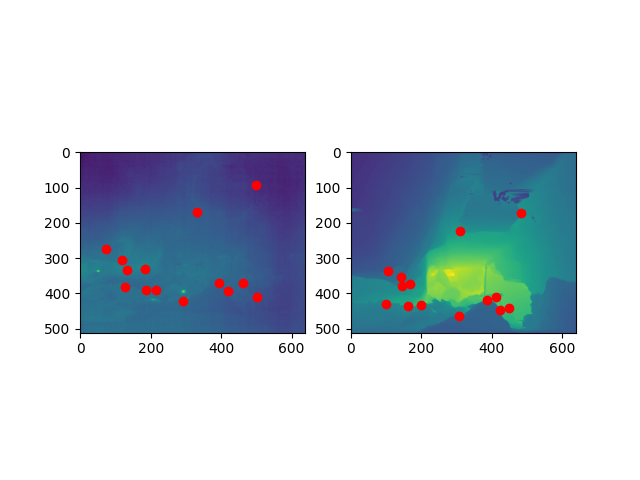

In [20]:
exp = Experiment( "/data/dmcp_experiments/dmcp_original", mesh_path)

imIm = exp.load_imIm()
imK = exp.load_imK()
imP = exp.load_imP()

dmIm = exp.load_dmIm()
dmK = exp.load_dmK()
dmP = exp.load_dmP()

cps = exp.load_cps()

#print(cps)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(imIm)
plt.scatter(cps[:,0],cps[:,1],c="r")
plt.subplot(1,2,2)
plt.imshow(dmIm)
plt.scatter(cps[:,2],cps[:,3],c="r")
plt.show()

In [21]:
from src.pycv.dmcp import dm_to_world

pts_world = dm_to_world(dmIm, dmK, dmP, cps[:,2:])

In [22]:
imP

array([[    511.00,       0.00,     320.00],
       [      0.00,     511.00,     256.00],
       [      0.00,       0.00,       1.00]])